# Optimization of Employee Shuttle Stops

***

## Goal

It is a common practice for tech companies to use shuttle buses to ferry their employees from home to the office. The goal of this project is to figure out the optimal stops for a bus shuttle. The company is based in Mountain View and the shuttle provides transportation for employees based in San Francisco.

With the explosion of user location data, data science can be used to optimize many of the services cities offer to their citizens. Transportation optimization is an example of that, but there are so many other possible applications. All this often goes under the (buzz name) "smart city" and it is one of the most interesting future applications of data science. 

***

## Challenge Description

Company XYZ has decided to offer a shuttle bus to help its employees commute from San Francisco to Mountain View. The city of San Francisco has given the company a list of potential bus stop locations to choose from and asked to not have more than 10 stops within the city. 

You have been given the home address of all employees interested in taking the shuttle and asked to come up with the ten most efficient stops. While you have been given a certain freedom in defining what is "efficient", the general consensus within the company is that the most efficient way to select the bus stops is to **minimize the overall walking distance between employee homes and the closest bus stop**.

Estimating all possible 10 stop combinations would require a lot of time (how many combinations would that be?). Therefore, your boss is fine with simplifying the problem and returning 10 stops that have a high probability of being the best stops. 

**You should write an algorithm that returns the best 10 stops in your opinion. Also, please explain the rationale behind the algorithm**. 

## Data

We have 2 tables downloadable by clicking [here](https://drive.google.com/uc?export=download&id=0B5G7QmUBc4IRRVlwWkNqcHFLajg).

The 2 tables are:


```
"Potential_Bus_Stops" - this is the list of potential bus stops given by San Francisco to the company. Is is a list of intersections in the city.
```

**Columns:**  
- **Street_One** : one of the two streets intersecting
- **Street_Two** : the other street intersecting

***

```
"Employee_Adresses" - the home address of each employee interested in taking the shuttle. 
```

**Columns:**
- **address** : employee address
- **employee_id** : employee id, unique by employee


## Example 

```
Let's check the first bus stop candidate:
```

**head(Potential_Bus_Stops, 1)**

| Column Name | Value | Description |
| --- | --- | --- | 
| Street_One | MISSION ST | One of the two streets intersecting is Mission St | 
| Street_Two | ITALY AVE | The second street is Italy Ave |

That is, the bus stop candidate is [here](https://www.google.com/maps/place/Mission+St+&+Italy+Ave,+San+Francisco,+CA+94112/@37.718502,-122.4417168,17z/data=!3m1!4b1!4m2!3m1!1s0x808f7e84ca494f5f:0x2df00894d53958f7)

***

```
Let's now check where one employee lives:
```

**head(Employee_Addresses, 1)**

| Column Name | Value | Description | 
| --- | --- | --- |
| address | 98 Edinburgh St, San Francisco, CA 94112, USA | She lives in Edinburgh St | 
| employee_id | 206 | Her employee id is 206 |

That is, that employee lives [here](https://www.google.com/maps/place/98+Edinburgh+St,+San+Francisco,+CA+94112/@37.72748,-122.4622997,13z/data=!4m2!3m1!1s0x808f7e8b755d4be7:0xbe1ffe39292712a6)

In [2]:
%matplotlib inline

# Import packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)     # Set default figure size

## Import the Datasets

Both datasets are imported to a DataFrame using Pandas read_csv() method. 

In [3]:
# Import both csv files for potential bus stops and employee addresses using pandas
potential_bus_stops = pd.read_csv('data/Potential_Bus_Stops.csv')
employee_addresses = pd.read_csv('data/Employee_Addresses.csv')

## Exploratory Data Analysis

Some exploratory data analysis is required in order to extract some useful information about our data.

***Potential Bus Stops Dataset***

In [4]:
# Observe head of potential bus stops dataset
potential_bus_stops.head()

,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,01ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


It is noted that the third bus stop's "Street_Two" attribute denotes "1ST STREET" as "01ST STREET". This can be a problem when geocoding the address. It is observed that all numbered cross streets below "10" have a 0 prefixed. We want to modify this attribute and remove the 0 prefix to make the attribute more realistic when geocoding the addresses. 

In [5]:
# Check that first character of street starts with '0' and drop the '0' from it
for index, street in enumerate(potential_bus_stops['Street_Two']):
    if street.startswith('0'):
        print('Updated', street)
        potential_bus_stops['Street_Two'][index] = street[1:]

# Confirm that the '0' is dropped by observing the head of the dataset
potential_bus_stops.head()

Updated 01ST ST
Updated 02ND ST
Updated 06TH ST
Updated 08TH ST
Updated 04TH ST
Updated 03RD ST
Updated 07TH ST
Updated 09TH ST
Updated 05TH ST


,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,1ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


We can see now that in the third row, it is properly labelled as "1ST ST" instead of "01ST ST" prior to our update. 

In [6]:
# Print summary data of potential bus stops data
potential_bus_stops.describe()

,Street_One,Street_Two
count,119,119
unique,1,119
top,MISSION ST,LAFAYETTE ST
freq,119,1


In [7]:
# Observe unique vlaues for Street_One
potential_bus_stops.Street_One.unique()

array(['MISSION ST'], dtype=object)

In [8]:
# Shape of the data (119 rows x 2 columns)
potential_bus_stops.shape

(119, 2)

In [9]:
# Check if there are any missing values ('NaN') in the dataset
potential_bus_stops.isnull().sum()

Street_One    0
Street_Two    0
dtype: int64

This dataset is already formatted and does not require any modifications in the structure (e.g. column names, missing values, etc.). 

Observations  
1. There are 119 possible bus stops (we want to choose the 10 best stops for our route)
2. All stops for ```Street_One``` are the same ("MISSION ST")
3. There are no missing values

***Employee Addresses Dataset***

In [10]:
# Observe head of employee addresses dataset
employee_addresses.head()

,address,employee_id
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206
1,"237 Accacia St, Daly City, CA 94014, USA",2081
2,"1835 Folsom St, San Francisco, CA 94103, USA",178
3,"170 Cambridge St, San Francisco, CA 94134, USA",50
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863


In [11]:
# Shape of the data (2191 rows x 2 columns)
employee_addresses.shape

(2191, 2)

In [12]:
# Check if there are any missing values ('NaN') in the dataset
employee_addresses.isnull().sum()

address        0
employee_id    0
dtype: int64

## Extracting Latitude/Longitude with Geocoder

Using the [geocoder](https://geocoder.readthedocs.io/) library in Python, we can obtain latitude and longitude information about each address. 

***Combine Bus Stops into "Street_One & Street_Two"***

For cross-street address querying, the API takes the address in the format: "Street_One & Street_Two".
There, we must first combine Street_One and Street_Two into a single string in the accepted format in order to pass to the geocoder to decode the latitude and longitude for each cross-street address. 

In [13]:
def concat_address(street_one, street_two):
    """Function to concatenate Street_One and Street_Two with an ampersand.
    """
    return str(street_one + ' & ' + street_two + ' SAN FRANCISCO, CA')

In [14]:
# Call the concat_address functions to concatenate Street_One with Street_Two
bus_stops = [concat_address(potential_bus_stops['Street_One'][i], potential_bus_stops['Street_Two'][i]) 
             for i in range(potential_bus_stops.shape[0])]

# Add this as a new column to the original dataset
potential_bus_stops['Cat_Bus_Stops'] = bus_stops

# Observe updated DataFrame
potential_bus_stops.head()

,Street_One,Street_Two,Cat_Bus_Stops
0,MISSION ST,ITALY AVE,"MISSION ST & ITALY AVE SAN FRANCISCO, CA"
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA"
2,MISSION ST,1ST ST,"MISSION ST & 1ST ST SAN FRANCISCO, CA"
3,MISSION ST,20TH ST,"MISSION ST & 20TH ST SAN FRANCISCO, CA"
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA"


In [51]:
# Import geocoder library to geocode addresses through MapQuest's platform
import geocoder

# MapQuest geocoder API key
# https://developer.mapquest.com/documentation/geocoding-api/
MAPQUEST_API_KEY = 'INSERT_MAP_QUEST_API_KEY_HERE'

def geocode_address(address, key=MAPQUEST_API_KEY):
    """Help function to call the geocoder API to extract latitude/longitude information.
    """
    geocode_object = geocoder.mapquest(address, key=key)
    lat, lng = geocode_object.lat, geocode_object.lng
    print('Successfully geocoded for address:', address)
    return lat, lng

In [16]:
# Geocode potential bus stop addresses
bus_stop_latlng = [geocode_address(bus_stop) for bus_stop in bus_stops]

Successfully geocoded for address: MISSION ST & ITALY AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 1ST ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 20TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & FREMONT ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 13TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ERIE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & BEALE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & FAIR AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & SAINT MARYS AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & SENECA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ANTHONY ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & JESSIE EAST ST SAN FRANCISCO, CA
S

Successfully geocoded for address: MISSION ST & WASHBURN ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & MORSE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ANGELOS ALY SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & BROOK ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 9TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & OTTAWA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & NIAGARA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ACTON ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 5TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 24TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & GRACE ST SAN FRANCISCO, CA


In [17]:
bus_stop_lat, bus_stop_lng = zip(*bus_stop_latlng)

In [18]:
potential_bus_stops['Lat'] = bus_stop_lat
potential_bus_stops['Lng'] = bus_stop_lng
potential_bus_stops.head()

,Street_One,Street_Two,Cat_Bus_Stops,Lat,Lng
0,MISSION ST,ITALY AVE,"MISSION ST & ITALY AVE SAN FRANCISCO, CA",37.718449,-122.439524
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA",37.787457,-122.400492
2,MISSION ST,1ST ST,"MISSION ST & 1ST ST SAN FRANCISCO, CA",37.789776,-122.397555
3,MISSION ST,20TH ST,"MISSION ST & 20TH ST SAN FRANCISCO, CA",37.758638,-122.419049
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA",37.790457,-122.396691


In [19]:
employee_addresses.head()

,address,employee_id
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206
1,"237 Accacia St, Daly City, CA 94014, USA",2081
2,"1835 Folsom St, San Francisco, CA 94103, USA",178
3,"170 Cambridge St, San Francisco, CA 94134, USA",50
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863


In [20]:
# Geocode employee addresses
employee_latlng = [geocode_address(address) for address in employee_addresses['address']]

Successfully geocoded for address: 98 Edinburgh St, San Francisco, CA 94112, USA
Successfully geocoded for address: 237 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 1835 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 170 Cambridge St, San Francisco, CA 94134, USA
Successfully geocoded for address: 16 Roanoke St, San Francisco, CA 94131, USA
Successfully geocoded for address: 222 Whittier St, Daly City, CA 94014, USA
Successfully geocoded for address: 13 Hyde St, San Francisco, CA 94102, USA
Successfully geocoded for address: 2919 Geneva Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 100 Larkin St, San Francisco, CA 94102, USA
Successfully geocoded for address: 230 Murray St, San Francisco, CA 94112, USA
Successfully geocoded for address: 45 Sanchez St, San Francisco, CA 94114, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 838 Schwerin St, Daly 

Successfully geocoded for address: 98 Erie St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 6 Mateo St, San Francisco, CA 94131, USA
Successfully geocoded for address: 1433 Silliman St, San Francisco, CA 94134, USA
Successfully geocoded for address: 680 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 1200 15th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 899 14th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 36 Maynard St, San Francisco, CA 94112, USA
Successfully geocoded for address: 518 Laidley St, San Francisco, CA 94131, USA
Successfully geocoded for address: 3380 Mission St, San Francisco, CA 94110, USA
Successfully geocoded for address: 140 Charter Oak Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 720 Morse St, San Francisco, CA 94112, USA
Successfully geocoded for address: 2150 Alema

Successfully geocoded for address: 2273 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 69 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 855 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 121 Tiffany Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 194 Park St, San Francisco, CA 94110, USA
Successfully geocoded for address: 3200 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 124 Leese St, San Francisco, CA 94110, USA
Successfully geocoded for address: 1750 Harrison St, San Francisco, CA 94103, USA
Successfully geocoded for address: 158 27th St, San Francisco, CA 94110, USA
Successfully geocoded for address: 625 Bayshore Blvd, San Francisco, CA 94124, USA
Successfully geocoded for address: 20 Curtis St, San Francisco, CA 94112, USA
Successfully geocoded for address: 94 Joost Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 3161 Sacrame

Successfully geocoded for address: St. Luke's Hospital Garage, San Francisco, CA 94110, USA
Successfully geocoded for address: 2600 Union St, San Francisco, CA 94123, USA
Successfully geocoded for address: 440 Hanover St, San Francisco, CA 94112, USA
Successfully geocoded for address: 599 Bosworth St, San Francisco, CA 94131, USA
Successfully geocoded for address: 2345 Filbert St, San Francisco, CA 94123, USA
Successfully geocoded for address: 598 Persia Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 6 Madison St, San Francisco, CA 94134, USA
Successfully geocoded for address: 11 Roanoke St, San Francisco, CA 94131, USA
Successfully geocoded for address: 524 Moscow St, San Francisco, CA 94112, USA
Successfully geocoded for address: 501 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 891 Foerster St, San Francisco, CA 94127, USA
Successfully geocoded for address: 3201 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for a

Successfully geocoded for address: 25 Lippard Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 21 Noe St, San Francisco, CA 94114, USA
Successfully geocoded for address: 455 Golden Gate Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 899 Moscow St, San Francisco, CA 94112, USA
Successfully geocoded for address: 183 Oxford St, San Francisco, CA 94134, USA
Successfully geocoded for address: 728 Brunswick St, San Francisco, CA 94112, USA
Successfully geocoded for address: 658 Silver Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 1390 Market St, San Francisco, CA 94102, USA
Successfully geocoded for address: 48 Cayuga Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 250 Valencia St, San Francisco, CA 94103, USA
Successfully geocoded for address: 792 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 312 Leland Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 21 Lyell

Successfully geocoded for address: 45 Chilton Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 2200 Market St, San Francisco, CA 94114, USA
Successfully geocoded for address: 25 Essex St, San Francisco, CA 94105, USA
Successfully geocoded for address: 98 Polk St, San Francisco, CA 94102, USA
Successfully geocoded for address: 473 Chenery St, San Francisco, CA 94131, USA
Successfully geocoded for address: 318 Excelsior Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 1800 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 199 Acton St, Daly City, CA 94014, USA
Successfully geocoded for address: 1749 Harrison St, San Francisco, CA 94103, USA
Successfully geocoded for address: 207 Morse St, San Francisco, CA 94112, USA
Successfully geocoded for address: 3235 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for address: 611 Folsom St, San Francisco, CA 94107, USA
Successfully geocoded for address: 91 Henry St, San F

Successfully geocoded for address: 50 28th St, San Francisco, CA 94110, USA
Successfully geocoded for address: 4963 Mission St, San Francisco, CA 94112, USA
Successfully geocoded for address: 2685 Diamond St, San Francisco, CA 94131, USA
Successfully geocoded for address: 302 Potrero Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 1919 Baker St, San Francisco, CA 94115, USA
Successfully geocoded for address: 808 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 237 Oxford St, San Francisco, CA 94134, USA
Successfully geocoded for address: 215 Harvard St, San Francisco, CA 94134, USA
Successfully geocoded for address: 801 Silver Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 1063 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 25 Belcher St, San Francisco, CA 94114, USA
Successfully geocoded for address: 2925 Geneva Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 146 Lo

Successfully geocoded for address: 78 Sanchez St, San Francisco, CA 94114, USA
Successfully geocoded for address: 1218 Market St, San Francisco, CA 94102, USA
Successfully geocoded for address: 2134 Market St, San Francisco, CA 94114, USA
Successfully geocoded for address: 1138 Cayuga Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 3100 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1599 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 146 Paris St, San Francisco, CA 94112, USA
Successfully geocoded for address: 575 Athens St, San Francisco, CA 94112, USA
Successfully geocoded for address: 2460 Alameda St, San Francisco, CA 94103, USA
Successfully geocoded for address: 310 Alemany Blvd, San Francisco, CA 94110, USA
Successfully geocoded for address: 572 Harrison St, San Francisco, CA 94105, USA
Successfully geocoded for address: 1612 Dolores St, San Francisco, CA 94110, USA
Successfully geocoded for address:

Successfully geocoded for address: 60 Pierce St, San Francisco, CA 94117, USA
Successfully geocoded for address: 3234 Sacramento St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1488 Harrison St, San Francisco, CA 94103, USA
Successfully geocoded for address: 45 Conkling St, San Francisco, CA 94124, USA
Successfully geocoded for address: 349 2nd St, San Francisco, CA 94107, USA
Successfully geocoded for address: 338 Bosworth St, San Francisco, CA 94112, USA
Successfully geocoded for address: 164 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 421 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 718 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 2740 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 100 Larkin St, San Francisco, CA 94102, USA
Successfully geocoded for address: 95 Scotia Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 1940 Harris

Successfully geocoded for address: 150 Hayes St, San Francisco, CA 94102, USA
Successfully geocoded for address: 231 Acton St, Daly City, CA 94014, USA
Successfully geocoded for address: 255 Gambier St, San Francisco, CA 94134, USA
Successfully geocoded for address: 169 Boutwell St, San Francisco, CA 94124, USA
Successfully geocoded for address: 158 Duncan St, San Francisco, CA 94110, USA
Successfully geocoded for address: 941 Naples St, San Francisco, CA 94112, USA
Successfully geocoded for address: 121 Harvard St, San Francisco, CA 94134, USA
Successfully geocoded for address: 18 Day St, San Francisco, CA 94110, USA
Successfully geocoded for address: 1798 Visitacion Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 361 Frankfort St, Daly City, CA 94014, USA
Successfully geocoded for address: 1700 Silver Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 38 Robblee Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 698 Twin Peaks 

Successfully geocoded for address: 118 Roanoke St, San Francisco, CA 94131, USA
Successfully geocoded for address: 148 Polk St, San Francisco, CA 94102, USA
Successfully geocoded for address: 1162 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 427 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 3086 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1025 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 524 Vienna St, San Francisco, CA 94112, USA
Successfully geocoded for address: 2200 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 2789 Diamond St, San Francisco, CA 94131, USA
Successfully geocoded for address: 39 W View Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 375 Teddy Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 71 Lyell St, San Francisco, CA 94112, USA
Successfully geocoded for address: 166 Ed

Successfully geocoded for address: 3062 California St, San Francisco, CA 94115, USA
Successfully geocoded for address: 420 Leland Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 2273 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 814 Rolph St, San Francisco, CA 94112, USA
Successfully geocoded for address: 850 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 780 Delta St, San Francisco, CA 94134, USA
Successfully geocoded for address: 3125 Scott St, San Francisco, CA 94123, USA
Successfully geocoded for address: 769 San Jose Avenue, San Francisco, CA 94110, USA
Successfully geocoded for address: 172 Oxford St, San Francisco, CA 94134, USA
Successfully geocoded for address: 337 Avalon Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 1580 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 25 Adair St, San Francisco, CA 94103, USA
Successfully geocoded for address: 426A Boswo

Successfully geocoded for address: 149 London St, San Francisco, CA 94112, USA
Successfully geocoded for address: 500 Raymond Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 3800 10th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 23 Waterville St, San Francisco, CA 94124, USA
Successfully geocoded for address: 198 Florida St, San Francisco, CA 94103, USA
Successfully geocoded for address: 37 Addison St, San Francisco, CA 94131, USA
Successfully geocoded for address: 2351 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 524 Vienna St, San Francisco, CA 94112, USA
Successfully geocoded for address: 54 Addison St, San Francisco, CA 94131, USA
Successfully geocoded for address: 132 Lippard Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 373 Frankfort St, Daly City, CA 94014, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2456 Filbert 

Successfully geocoded for address: 155 Hayes St, San Francisco, CA 94102, USA
Successfully geocoded for address: 2009 Lyon St, San Francisco, CA 94115, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 98 Cuvier St, San Francisco, CA 94112, USA
Successfully geocoded for address: 599 9th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 360 Frankfort St, Daly City, CA 94014, USA
Successfully geocoded for address: 627 14th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 198 Crescent Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 130 Madrid St, San Francisco, CA 94112, USA
Successfully geocoded for address: 8 Risel Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 3228 Sacramento St, San Francisco, CA 94115, USA
Successfully geocoded for address: 851 14th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 128 Lippard Ave, San Franci

Successfully geocoded for address: 236 Oxford St, San Francisco, CA 94134, USA
Successfully geocoded for address: 1154 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 116 Maddux Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 145A Hampshire St, San Francisco, CA 94103, USA
Successfully geocoded for address: 302 Van Ness Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 98 Norfolk St, San Francisco, CA 94103, USA
Successfully geocoded for address: 499 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 1599 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 120 Madrid St, San Francisco, CA 94112, USA
Successfully geocoded for address: 211 Seneca Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 9 Duncan St, San Francisco, CA 94110, USA
Successfully geocoded for address: 642 Harrison St, San Francisco, CA 94107, USA
Successfully geocoded for address: 875

Successfully geocoded for address: 1237 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 3091 Sacramento St, San Francisco, CA 94115, USA
Successfully geocoded for address: 198 Newton St, San Francisco, CA 94112, USA
Successfully geocoded for address: 101, San Francisco, CA 94124, USA
Successfully geocoded for address: 237 Acton St, Daly City, CA 94014, USA
Successfully geocoded for address: 216 Whittier St, Daly City, CA 94014, USA
Successfully geocoded for address: 450 McAllister St, San Francisco, CA 94102, USA
Successfully geocoded for address: 310 Alemany Blvd, San Francisco, CA 94110, USA
Successfully geocoded for address: 99 Schwerin St, San Francisco, CA 94134, USA
Successfully geocoded for address: 3243 Mission St, San Francisco, CA 94110, USA
Successfully geocoded for address: 851 Edinburgh St, San Francisco, CA 94112, USA
Successfully geocoded for address: 162 S Van Ness Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 924 Nap

Successfully geocoded for address: 2150 Market St, San Francisco, CA 94114, USA
Successfully geocoded for address: 869 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 162B Sussex St, San Francisco, CA 94131, USA
Successfully geocoded for address: 92 Curtis St, San Francisco, CA 94112, USA
Successfully geocoded for address: 282 12th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 555 San Jose Avenue, San Francisco, CA 94110, USA
Successfully geocoded for address: 18 Ney St, San Francisco, CA 94112, USA
Successfully geocoded for address: 215 Madrid St, San Francisco, CA 94112, USA
Successfully geocoded for address: 8 10th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 429 Laidley St, San Francisco, CA 94131, USA
Successfully geocoded for address: 65 Oneida Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 476 Chenery St, San Francisco, CA 94131, USA
Successfully geocoded for address: 148 Sussex St, San F

Successfully geocoded for address: 2374 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 154 Cuvier St, San Francisco, CA 94112, USA
Successfully geocoded for address: 889 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 398 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 1390 Market St, San Francisco, CA 94102, USA
Successfully geocoded for address: 26 Mercury St, San Francisco, CA 94124, USA
Successfully geocoded for address: 451 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 1142 Munich St, San Francisco, CA 94112, USA
Successfully geocoded for address: 333 Melrose Ave, San Francisco, CA 94127, USA
Successfully geocoded for address: 1658 Valencia St, San Francisco, CA 94110, USA
Successfully geocoded for address: 275 Perry St, San Francisco, CA 94107, USA
Successfully geocoded for address: 685 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 50 Alberta

Successfully geocoded for address: 20 Mangels Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 600 Templeton Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 1798 Visitacion Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 98 Everson St, San Francisco, CA 94131, USA
Successfully geocoded for address: 2116 Lyon St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1699 Howard St, San Francisco, CA 94103, USA
Successfully geocoded for address: 238 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 141 Hampshire St, San Francisco, CA 94103, USA
Successfully geocoded for address: 560 Vienna St, San Francisco, CA 94112, USA
Successfully geocoded for address: 699 Bayshore Blvd, San Francisco, CA 94124, USA
Successfully geocoded for address: 26 Athens St, San Francisco, CA 94112, USA
Successfully geocoded for address: 39 Risel Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 2148 15th 

Successfully geocoded for address: 74 Arnold Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 3170 Sacramento St, San Francisco, CA 94115, USA
Successfully geocoded for address: 869 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 1349 San Jose Avenue, San Francisco, CA 94131, USA
Successfully geocoded for address: 405 Allison St, San Francisco, CA 94112, USA
Successfully geocoded for address: 1991 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 598 Harrison St, San Francisco, CA 94105, USA
Successfully geocoded for address: 342 Elliot St, San Francisco, CA 94134, USA
Successfully geocoded for address: 2010 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 322 Oliver St, Daly City, CA 94014, USA
Successfully geocoded for address: 170 Cora St, San Francisco, CA 94134, USA
Successfully geocoded for address: 551 Templeton Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 17

Successfully geocoded for address: 143 Winchester St, Daly City, CA 94014, USA
Successfully geocoded for address: 380 10th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 1 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 2124 15th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 650 Duboce Ave, San Francisco, CA 94117, USA
Successfully geocoded for address: 375 Silver Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 125 Peru Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 116 Miguel St, San Francisco, CA 94131, USA
Successfully geocoded for address: 3018 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 2945 Scott St, San Francisco, CA 94123, USA
Successfully geocoded for address: 1479 Guerrero St, San Francisco, CA 94110, USA
Successfully geocoded for address: 2727 Pierce St, San Francisco, CA 94123, USA
Successfully geocoded for address: 148 Noe St, S

Successfully geocoded for address: 4364 Mission St, San Francisco, CA 94112, USA
Successfully geocoded for address: 299 Shotwell St, San Francisco, CA 94110, USA
Successfully geocoded for address: 120 Topeka Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 330 10th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 443 Bosworth St, San Francisco, CA 94112, USA
Successfully geocoded for address: 266 Hayes St, San Francisco, CA 94102, USA
Successfully geocoded for address: 162 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 72 Topeka Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 330 Oliver St, Daly City, CA 94014, USA
Successfully geocoded for address: 94 W View Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 1599 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 499 Treat Ave, San Francisco, CA 94110, USA


In [21]:
employee_lat, employee_lng = zip(*employee_latlng)

employee_addresses['Lat'] = employee_lat
employee_addresses['Lng'] = employee_lng

employee_addresses.head()

,address,employee_id,Lat,Lng
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.727450,-122.427319
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.704247,-122.416106
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.767987,-122.415574
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.729636,-122.419484
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.736388,-122.431089


## Data Visualization

Using the latitude and longitude information about the potential bus stops and employee addresses, we are able to visualize the data on a scatterplot. 

Text(0.5,1,'Potential Bus Stops')

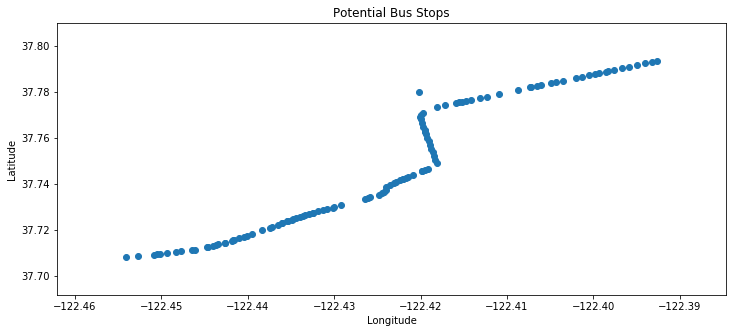

In [22]:
# Potential Bus Stops
plt.figure()
plt.scatter(potential_bus_stops['Lng'], potential_bus_stops['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Potential Bus Stops')

Text(0.5,1,'Employee Locations')

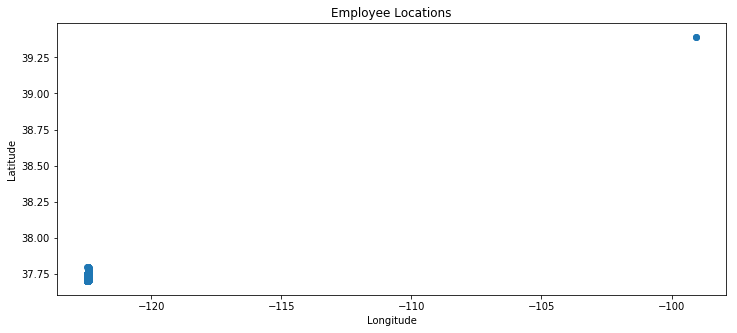

In [23]:
# Employee Addresses
plt.figure()
plt.scatter(employee_addresses['Lng'], employee_addresses['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Employee Locations')

## Data Cleaning

From looking at the scatterplot of the employee addresses, we can see that there is an outlier at roughly 39.4 Latitude and -99 Longitude (which is an address located in Kansas. We want to extract that employee's information and possibly remove the data temporarily to visualize the distribution of employees more clustered around 37.75 Latitude and -122 Longitude (San Francisco).

In [24]:
# Get employee addresses that are the outliers. 
employee_addresses[employee_addresses['Lat'] > 38.00]

,address,employee_id,Lat,Lng
474,San Francisco War Memorial and Performing Arts...,1814,39.390897,-99.066067
1644,San Francisco War Memorial and Performing Arts...,760,39.390897,-99.066067


In [25]:
# Observe the addresses closely
outlier1 = employee_addresses.iloc[474, 0]
outlier2 = employee_addresses.iloc[1644, 0]

In [26]:
print('First outlier address:', outlier1)
print('Second outlier address:', outlier2)
print('First outlier == second outlier: ', outlier1==outlier2)

First outlier address: San Francisco War Memorial and Performing Arts Center, 301 Van Ness Ave, San Francisco, CA 94102, USA
Second outlier address: San Francisco War Memorial and Performing Arts Center, 301 Van Ness Ave, San Francisco, CA 94102, USA
First outlier == second outlier:  True


We observe that this is in fact a San Francisco address and not a Kansas address. Therefore, something must have been wrong in geocoding this address. Also note that it is the same address, but they belong to two different employee ID's, therefore we should not remove any of them for this reason (not a duplicate).

In [27]:
# Geocode the address, keeping the name of the building
old_lat, old_lng = geocode_address(outlier1)
print('lat:', old_lat, 'lng:', old_lng)

Successfully geocoded for address: San Francisco War Memorial and Performing Arts Center, 301 Van Ness Ave, San Francisco, CA 94102, USA
lat: 39.390897 lng: -99.066067


In [28]:
# Remove the name of the building and keep the raw address only
outlier_fixed = outlier1.split(',', maxsplit=1)[1]
print('Updated address:', outlier_fixed)

# Geocode the address with the updated address, and observe the results
new_lat, new_lng = geocode_address(outlier_fixed)
print('lat:', new_lat, 'lng:', new_lng)

Updated address:  301 Van Ness Ave, San Francisco, CA 94102, USA
Successfully geocoded for address:  301 Van Ness Ave, San Francisco, CA 94102, USA
lat: 37.779156 lng: -122.420148


We see now that this fixed the issue, and gave us latitude and longitude values which were well within the correct geographic area as our other data. Let's update the employee_addresses data with these new results. 

In [29]:
# Fix line 474 
employee_addresses.iloc[474, 0] = outlier_fixed
employee_addresses.iloc[474, 2] = new_lat
employee_addresses.iloc[474, 3] = new_lng

# Fix line 1644
employee_addresses.iloc[1644, 0] = outlier_fixed
employee_addresses.iloc[1644, 2] = new_lat
employee_addresses.iloc[1644, 3] = new_lng

# Observe the two lines
employee_addresses.iloc[[474, 1644]]

,address,employee_id,Lat,Lng
474,"301 Van Ness Ave, San Francisco, CA 94102, USA",1814,37.779156,-122.420148
1644,"301 Van Ness Ave, San Francisco, CA 94102, USA",760,37.779156,-122.420148


Text(0.5,1,'Employee Locations')

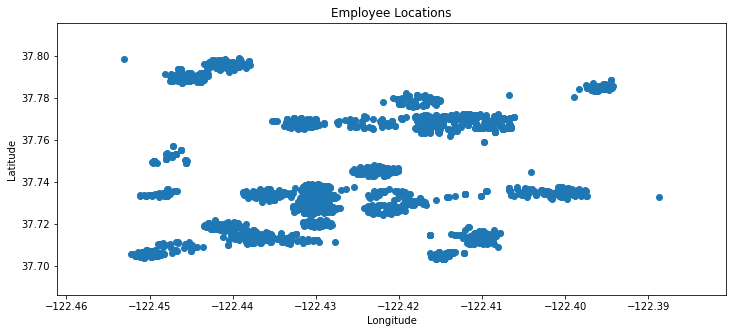

In [30]:
# Replot the data onto the employee addresses scatterplot
plt.figure()
plt.scatter(employee_addresses['Lng'], employee_addresses['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Employee Locations')

## Using Google Map's API to Plot Geographical Data

The plain scatterplots from the previous section may be helpful in visualizing the distribution of bus stops and employees. However, it may prove useful to visualize these locations on a real map for better intuition. The geographical data is plotted using Bokeh and Google Map's API in order to do this.  

https://cloud.google.com/maps-platform/  
http://bokeh.pydata.org/en/latest/docs/user_guide/geo.html

In [52]:
# To get a Google API key:
# https://developers.google.com/maps/documentation/javascript/get-api-key  
GOOGLE_API_KEY = 'INSERT_GOOGLE_API_KEY_HERE'

In [32]:
# Store latitude and longitude values in variables
bus_lat_list = potential_bus_stops['Lat']
bus_lng_list = potential_bus_stops['Lng']
empl_lat_list = employee_addresses['Lat']
empl_lng_list = employee_addresses['Lng']

In [33]:
from bokeh.io import output_notebook, output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

map_options = GMapOptions(lat=37.75, lng=-122.44, map_type='roadmap', zoom=12)
p = gmap(GOOGLE_API_KEY, map_options, title='San Francisco')

# Potential Bus Stop Data
bus_source = ColumnDataSource(data=dict(lat=bus_lat_list, lon=bus_lng_list))
p.circle(x='lon', y='lat', size=15, fill_color='blue', fill_alpha=0.8, source=bus_source)

# Employee Address Data
empl_source = ColumnDataSource(data=dict(lat=empl_lat_list, lon=empl_lng_list))
p.circle(x='lon', y='lat', size=15, fill_color='red', fill_alpha=0.5, source=empl_source)

# Use output_file() if you want to generate an html in currency directory for the figure.
# Use output_notebook() to display inline in Jupyter Notebook. 
# output_file('bus_stops.html')
output_notebook()
show(p)

Loading BokehJS ...

## Applying K-Means Clustering

In [36]:
from sklearn.cluster import KMeans

# Employee address data in longitude/latitude
X = np.array(list(zip(empl_lng_list, empl_lat_list)))
X

array([[-122.427319,   37.72745 ],
       [-122.416106,   37.704247],
       [-122.415574,   37.767987],
       ...,
       [-122.417235,   37.731018],
       [-122.429835,   37.712339],
       [-122.413902,   37.761883]])

In [47]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[-122.41272339,   37.70965915],
       [-122.4134534 ,   37.76991408],
       [-122.42812048,   37.7382492 ],
       [-122.44350495,   37.79249002],
       [-122.44178047,   37.71204303],
       [-122.40366074,   37.73498951],
       [-122.39617473,   37.78504441],
       [-122.43002897,   37.76799156],
       [-122.42708873,   37.72636311],
       [-122.44816507,   37.74478201]])

In [48]:
clstr_lng_list, clstr_lat_list = zip(*cluster_centers)

In [50]:
# Bus Stops
clstr_source = ColumnDataSource(data=dict(lat=clstr_lat_list, lon=clstr_lng_list))
p.circle(x='lon', y='lat', size=15, fill_color='green', fill_alpha=1, source=clstr_source)

# Use output_file() if you want to generate an html in currency directory for the figure.
# Use output_notebook() to display inline in Jupyter Notebook. 
# output_file('bus_stops.html')
output_notebook()
show(p)

Loading BokehJS ...